In [1]:
from typing import List
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display
import requests
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper, WikipediaAPIWrapper
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from langgraph.graph import MessagesState
from typing import Optional, Any, Dict, Set
import re
from transformers import pipeline
from langchain_community.tools.tavily_search import TavilySearchResults
import base64
import soundfile as sf
import io
import torch
from io import BytesIO
import mimetypes
import imghdr
from urllib.parse import urlparse
import os

C:\Users\Sadık\AppData\Local\Temp\ipykernel_22300\7167622.py:25: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from dotenv import load_dotenv  

load_dotenv()

api_key = os.getenv('GOOGLE_API_KEY')
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

if (api_key and TAVILY_API_KEY) :
    print("API keys loaded successfully!")  
else:
    raise ValueError("API key not found! Please check the .env file.")

API keys loaded successfully!


In [ ]:
def _setup_llm():
        """Set up the language model."""
        # Set up model with video capabilities
        generation_config = {
            "temperature": 0.0,
            "max_output_tokens": 2000,
            "candidate_count": 1,
        }
        
        safety_settings = {
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        }
        
        return ChatGoogleGenerativeAI(
            model="gemini-2.0-flash",
            google_api_key=api_key,
            temperature=0,
            max_output_tokens=2000,
            generation_config=generation_config,
            safety_settings=safety_settings,
            system_message=SystemMessage(content=("""
            You are an intelligent and capable AI assistant integrated with a set of tools. Your job is to understand the user's request, determine the best way to fulfill it, and use the tools provided when necessary to produce accurate and helpful results.

            Your behavior should follow these principles:
            - Always think step by step before answering.
            - Only respond after reasoning through the problem.
            - Use tools if the task requires external capabilities.
            - If a tool is used, return the result of the tool in a clear and user-friendly way.
            - If a task does not require tool use, complete it using your own capabilities.
            - Be concise but informative. Avoid unnecessary verbosity.
            - If the user input is unclear, ask clarifying questions before taking action.
            - Do not hallucinate results. If you're unsure, say so or use the appropriate tool.
            
            You can interact with tools, but you are not the tool yourself. Use them wisely and only when needed.
            
            Your goal is to be useful, precise, and aligned with the user's intent.
"""
            ))
        )

In [5]:
llm = _setup_llm()

In [6]:
asr = pipeline(
    "automatic-speech-recognition",
    model="facebook/wav2vec2-base-960h"
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


### Tools and Functions

In [8]:
def find_non_commutative_elements(table: Dict[str, Dict[str, str]]) -> Set[str]:
    """Identifies elements involved in non-commutative pairs for a given operation table."""
    elements = list(table.keys())
    non_commutative = set()
    
    for x in elements:
        for y in elements:
            if x != y and table[x][y] != table[y][x]:
                non_commutative.update({x, y})
    
    return non_commutative

def commutative_check_tool(self, state: dict) -> dict:
    """LangGraph tool that checks for non-commutative elements in the operation table. Checks which elements violate commutativity in the operation table"""

    table = state.get("operation_table")
    
    if not table:
        raise ValueError("Operation table not found in state")
    
    non_comm_elements = self.find_non_commutative_elements(table)
    
    return {
        **state,
        "non_commutative_elements": sorted(non_comm_elements),
        "is_commutative": len(non_comm_elements) == 0
    }

In [9]:
try:
    import filetype
except ImportError:
    filetype = None

try:
    import magic
    _magic_mime = magic.Magic(mime=True)
except ImportError:
    _magic_mime = None


def download_file_from_url(file_url: str):
    """
    Downloads a file from a URL and attempts to predict its extension
    using content-based detection. Handles None or empty URLs gracefully.
    
    Args:
        file_url: The URL of the file to be downloaded.
    
    Returns:
        tuple:
            - content (bytes | None): The raw data of the downloaded file, or None if URL is invalid.
            - ext (str | None): The predicted file extension (e.g., '.png', '.mp3'),
                                or None if the extension cannot be determined.
    """
    
    if not file_url:
        return None, None

    try:
        response = requests.get(file_url)
        response.raise_for_status()
        data = response.content
    except Exception:
        return None, None

    if filetype:
        kind = filetype.guess(data)
        if kind:
            return data, f".{kind.extension}"

    img_ext = imghdr.what(None, h=data)
    if img_ext:
        return data, f".{img_ext}"

    if _magic_mime:
        try:
            mime = _magic_mime.from_buffer(data)
            ext = mimetypes.guess_extension(mime)
            return data, ext
        except Exception:
            pass

    return data, None

In [10]:
def wiki_search(self, query: str) -> str:
    """Search Wikipedia for a query and return maximum 2 results.
    
    Args:
        query: The search query."""
    search_docs = WikipediaLoader(query=query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return formatted_search_docs

In [11]:
def _anylyze_python(data:str):
        """After downloading a file from a URL, if that file is a Python (.py) file, an analysis tool."""
        decoded_data = data.decode('utf-8') 
        formatted_data = decoded_data.encode().decode('unicode_escape') 
        return formatted_data

In [12]:
def text_from_excel(data:str):
    """After downloading a file from a URL, if that file is a excel file then use this function to see text format"""
    excel_bytes = data  
    
    excel_file = BytesIO(excel_bytes)
    df = pd.read_excel(excel_file, sheet_name=None)  
    
    text_output = ""
    for sheet_name, sheet_df in df.items():
        text_output += f"--- Sheet: {sheet_name} ---\n"
        text_output += sheet_df.to_string(index=False)
        text_output += "\n\n"
    
    return text_output

In [13]:
def transcribe_bytes(mp3_bytes: bytes) -> str:
    """
    Convert MP3 bytes to a 16 kHz waveform, then run ASR.
    """
    # Decode MP3 bytes into a numpy array & sample rate
    audio, sr = sf.read(io.BytesIO(mp3_bytes))
    if sr != 16000:
        # Resample if needed (you can use torchaudio or librosa here)
        import torchaudio
        audio = torchaudio.functional.resample(
            torch.tensor(audio).float(), orig_freq=sr, new_freq=16000
        ).numpy()
    # Pipeline accepts raw array
    result = asr(audio)
    return result["text"]

In [14]:
web_tool = TavilySearchResults(api_key=TAVILY_API_KEY)

### Agent

In [17]:
tools= [commutative_check_tool, wiki_search, web_tool]

In [19]:
llm_with_tools = llm.bind_tools(tools)

In [21]:
def assistant(state: MessagesState):
    prompt = state['messages']
    return {"messages": [llm_with_tools.invoke(prompt)]}

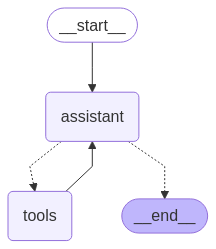

In [23]:
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)
# Show
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [25]:
file_url = input("Please enter a URL if you have one, otherwise you can leave it blank.")

Please enter a URL if you have one, otherwise you can leave it blank. https://agents-course-unit4-scoring.hf.space/files/1f975693-876d-457b-a649-393859e79bf3


In [27]:
question_text = input("Please enter your question or input here:")


Please enter your question or input here: Hi, I was out sick from my classes on Friday, so I'm trying to figure out what I need to study for my Calculus mid-term next week. My friend from class sent me an audio recording of Professor Willowbrook giving out the recommended reading for the test, but my headphones are broken :(\n\nCould you please listen to the recording for me and tell me the page numbers I'm supposed to go over? I've attached a file called Homework.mp3 that has the recording. Please provide just the page numbers as a comma-delimited list. And please provide the list in ascending order.


In [29]:
config = {"configurable": {"thread_id": "1"}}
data, extension = download_file_from_url(file_url)

if extension == ".py":
    final = _anylyze_python(data)
    answer =  react_graph.invoke({"messages":"Python Code:\n" + final+ "\n\n"+question_text}, config)   
elif extension == ".xlsx" or extension == ".xls":
    final= text_from_excel(data)
    answer = react_graph.invoke({"messages":"Excel file:\n" + final+"\n\n"+question_text}, config)  
elif extension == ".mp3":
    audio = transcribe_bytes(data)
    answer = react_graph.invoke({"messages":"This is audio data(.mp3), answer accordingly: "+audio +"\n\n" +question_text}, config)    
else:
    answer = react_graph.invoke({"messages": question_text}, config)

In [30]:
result = answer['messages'][-1].content 
print(result)

132, 133, 134, 197, 245
